### General Imports and Prep
Import the necessary libraries and prepare the image imports

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


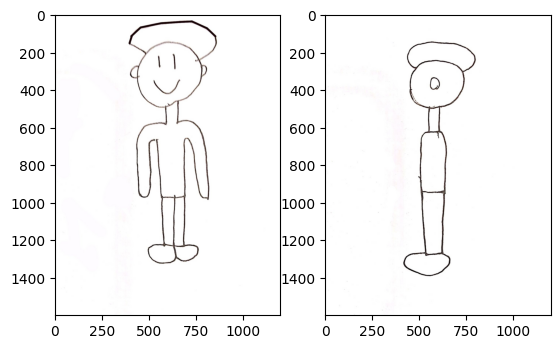

In [1]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.interpolate import splprep, splev
from skimage import measure
from scipy.spatial import ConvexHull
from scipy.spatial.distance import cdist
import pickle
import open3d as o3d

# Function to move points towards the center
def move_points_towards_center(points, center, step, threshold, edge_points):
    moved_points = []
    for point in points:
        while True:
            if np.any(np.all(np.isclose(edge_points, point, atol=threshold), axis=1)):
                break
            if abs(point[1] - center[1]) <= threshold:
                break
            if point[1] > center[1]:
                point[1] -= step
            else:
                point[1] += step
        moved_points.append(point)
    return np.array(moved_points)

# Function to reorder points to be next to their closest neighbors
def reorder_points(points, threshold):
    if len(points) < 2:
        return points
    ordered_points = [points[0]]
    points = points[1:]
    while len(points) > 0:
        last_point = ordered_points[-1]
        distances = cdist([last_point], points)
        nearest_index = np.argmin(distances)
        if distances[0, nearest_index] > threshold:
            break
        ordered_points.append(points[nearest_index])
        points = np.delete(points, nearest_index, axis=0)
    return np.array(ordered_points)

# Function to ensure that there are no gaps between points
def fill_gaps(points):
    filled_points = []
    for i in range(points.shape[1] - 1):
        start = points[:, i]
        end = points[:, i + 1]
        filled_points.append(start)
        while not np.array_equal(start, end):
            if start[0] < end[0]:
                start[0] += 1
            elif start[0] > end[0]:
                start[0] -= 1
            if start[1] < end[1]:
                start[1] += 1
            elif start[1] > end[1]:
                start[1] -= 1
            filled_points.append(start.copy())
    filled_points.append(points[:, -1])
    return np.array(filled_points).T

obj_front = cv2.imread("drawings/man-front.jpg")
obj_right = cv2.imread("drawings/man-right.jpg")
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(obj_front, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(obj_right, cv2.COLOR_BGR2RGB))
plt.show()

### Image Pre-processing
Binary threshold the images, and apply an edge detection algorithm to extract the lines

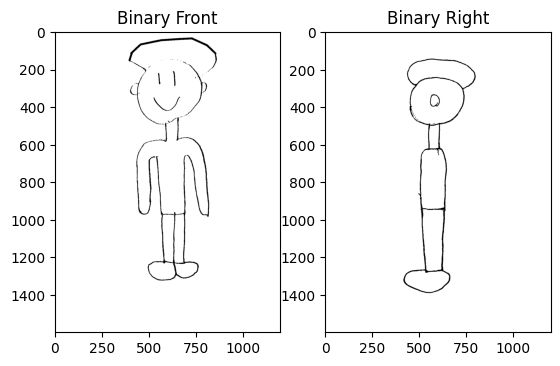

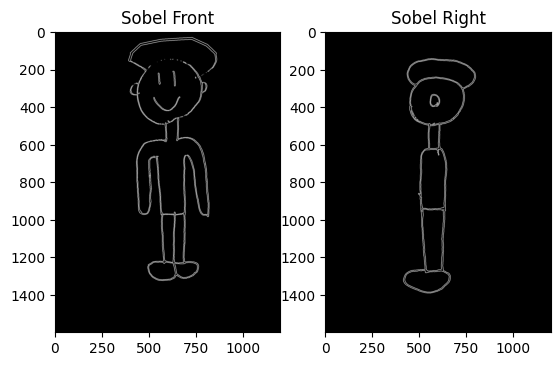

In [2]:
# Convert the image to grayscale
gray_obj_front = cv2.cvtColor(obj_front, cv2.COLOR_BGR2GRAY)
gray_obj_right = cv2.cvtColor(obj_right, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_, binary_obj_front = cv2.threshold(gray_obj_front, 127, 255, cv2.THRESH_BINARY)
_, binary_obj_right = cv2.threshold(gray_obj_right, 127, 255, cv2.THRESH_BINARY)

# Apply Sobel operator to find edges
sobelx = cv2.Sobel(binary_obj_front, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(binary_obj_front, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges_front = np.sqrt(sobelx**2 + sobely**2)
sobelx = cv2.Sobel(binary_obj_right, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(binary_obj_right, cv2.CV_64F, 0, 1, ksize=5)
sobel_edges_right = np.sqrt(sobelx**2 + sobely**2)

plt.subplot(1, 2, 1)
plt.imshow(binary_obj_front, cmap="gray"); plt.title("Binary Front")
plt.subplot(1, 2, 2)
plt.imshow(binary_obj_right, cmap="gray"); plt.title("Binary Right")
plt.show()
plt.subplot(1, 2, 1)
plt.imshow(sobel_edges_front, cmap="gray"); plt.title("Sobel Front")
plt.subplot(1, 2, 2)
plt.imshow(sobel_edges_right, cmap="gray"); plt.title("Sobel Right")
plt.show()


### Use the Convex Hull Algorithm To Simplify the Shape
Using the CVH algorithm, find the smallest line that encircles the entire image

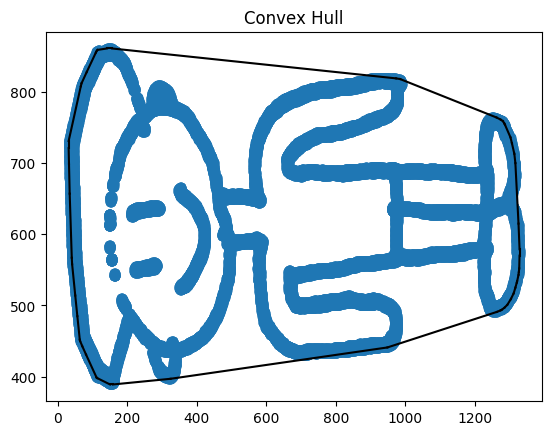

In [3]:
points_front = np.column_stack(np.where(sobel_edges_front > 0))
hull_front = ConvexHull(points_front)
plt.plot(points_front[:, 0], points_front[:, 1], "o")
plt.title('Points in the image')
for simplex in hull_front.simplices:
    plt.plot(points_front[simplex, 0], points_front[simplex, 1], 'k-')
plt.title('Convex Hull')

plt.show()

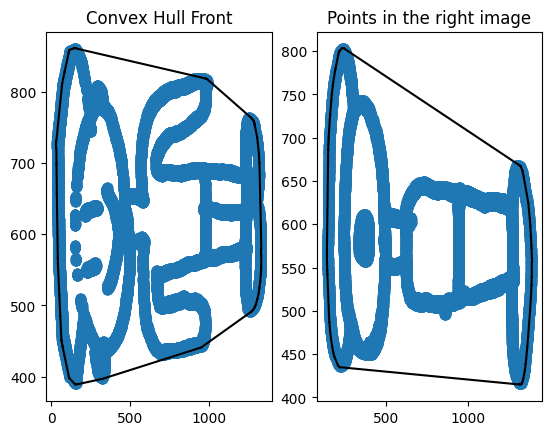

In [ ]:
# Reorder the points to make them compatible with the convex hull function
points_right = np.column_stack(np.where(sobel_edges_right > 0))

# Find the convex hull of the points
hull_right = ConvexHull(points_right)

plt.subplot(1, 2, 1)
plt.plot(points_front[:,0], points_front[:,1], 'o'); plt.title('Points in the front image')
for simplex in hull_front.simplices:
    plt.plot(points_front[simplex, 0], points_front[simplex, 1], 'k-')
plt.title('Convex Hull Front')
plt.subplot(1, 2, 2)
plt.plot(points_right[:,0], points_right[:,1], 'o'); plt.title('Points in the right image')
for simplex in hull_right.simplices:
    plt.plot(points_right[simplex, 0], points_right[simplex, 1], 'k-')
plt.show()

### Find the center and align the images
Find the center of each hull, and scale the side view to match the same width as the front view. 

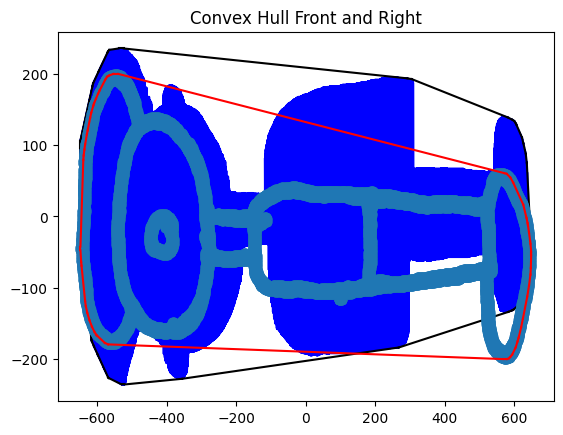

In [5]:
# Find the center of the points
x1 = hull_front.max_bound[0] - hull_front.min_bound[0]
y1 = hull_front.max_bound[1] - hull_front.min_bound[1]
center_front = (x1//2 + hull_front.min_bound[0], y1//2 + hull_front.min_bound[1])
x2 = hull_right.max_bound[0] - hull_right.min_bound[0]
y2 = hull_right.max_bound[1] - hull_right.min_bound[1]
center_right = (x2//2 + hull_right.min_bound[0], y2//2 + hull_right.min_bound[1])

# Re-align the points to the center
trans_front = points_front - center_front
trans_right = points_right - center_right
center = np.array([0, 0]) # Now that the images are centered, the center of both is at (0,0)

# Determine the scale factor
scale_factor = x1 / x2

# Scale the right view points to match the front view and recalculate the hull
scaled_points_right = trans_right * scale_factor
hull_right = ConvexHull(scaled_points_right)

plt.plot(trans_front[:,0], trans_front[:,1], 'b'); plt.title('Points in the front image')
for simplex in hull_front.simplices:
    plt.plot(trans_front[simplex, 0], trans_front[simplex, 1], 'k-')
plt.plot(scaled_points_right[:,0], scaled_points_right[:,1], 'o')
for simplex in hull_right.simplices:
    plt.plot(scaled_points_right[simplex, 0], scaled_points_right[simplex, 1], 'r-')
plt.title('Convex Hull Front and Right')   
plt.show()

### Interpolate the hull
Treating the hull as a spline, convert it to a set of points.
We can cheat a bit by only doing the next few steps for the front view

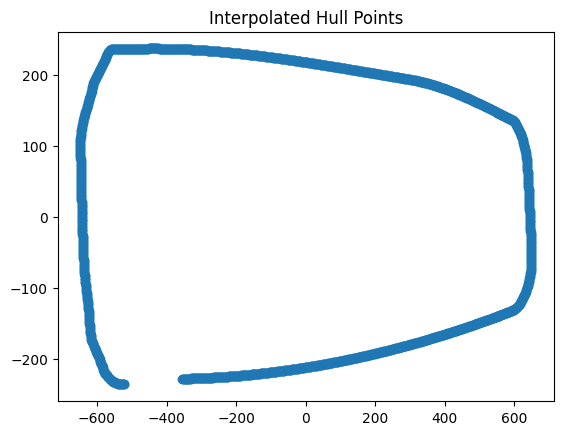

In [6]:
# Extract the hull points
hull_points = trans_front[hull_front.vertices]

# Create a parameterization of the hull points
tck, u = splprep([hull_points[:, 0], hull_points[:, 1]], s=0)

# Define the number of points you want on the hull
num_points = 1500

# Generate new points on the hull
new_points = splev(np.linspace(0, 1, num_points), tck)

# Convert the new points to a numpy array
new_hull_points = np.column_stack(new_points)

# Plot the new hull points
plt.plot(new_hull_points[:, 0], new_hull_points[:, 1], 'o')
plt.title('Interpolated Hull Points')
plt.show()

### Find the outline
Shrink fit the spline by moving all points towards the center until they touch the outline of the original image. 

This algorithm takes all the points of the interpolated hull, and pulls them towards the center until they come into contact with a point in the original image. It takes step and threshold inputs that control the step size and detection threshold respectively. Both can be tuned to affect the tradeoff between accuracy and time consumption.

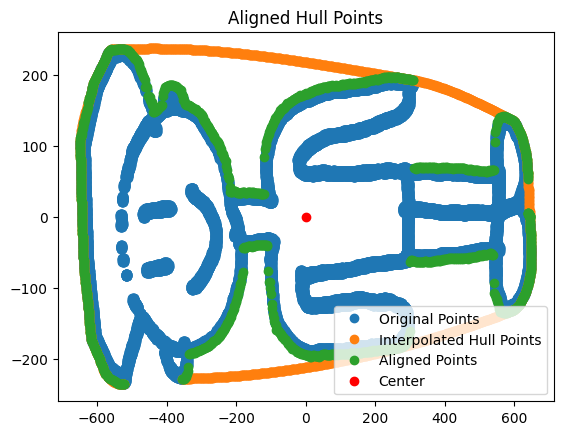

In [14]:
step = 1  # Define the step value
threshold = 2  # Define the threshold value

# Move the interpolated hull points towards the center
aligned_points = move_points_towards_center(new_hull_points.copy(), center, step, threshold, trans_front)

# We save the aligned points to a file since the process is time-consuming
np.savetxt('points/aligned_points_front.txt', aligned_points, delimiter=',')

# Plot the aligned points
plt.plot(trans_front[:, 0], trans_front[:, 1], 'o', label='Original Points')
plt.plot(new_hull_points[:, 0], new_hull_points[:, 1], 'o', label='Interpolated Hull Points')
plt.plot(aligned_points[:, 0], aligned_points[:, 1], 'o', label='Aligned Points')
plt.plot(center[0], center[1], 'ro', label='Center')
plt.legend()
plt.title('Aligned Hull Points')
plt.show()

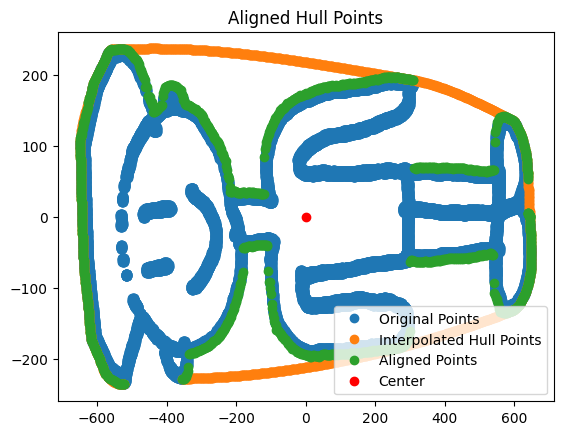

In [8]:
# If skipping the above cell, load the aligned points from file
aligned_points = np.loadtxt('points/aligned_points_front.txt', delimiter=',')

# Plot the aligned points
plt.plot(trans_front[:, 0], trans_front[:, 1], 'o', label='Original Points')
plt.plot(new_hull_points[:, 0], new_hull_points[:, 1], 'o', label='Interpolated Hull Points')
plt.plot(aligned_points[:, 0], aligned_points[:, 1], 'o', label='Aligned Points')
plt.plot(center[0], center[1], 'ro', label='Center')
plt.legend()
plt.title('Aligned Hull Points')
plt.show()

### Create Outline Spline
Reorder the points by distance from eachother, and convert them to a spline to connect the holes
(Removes any erroneous points outside a specific threshold)

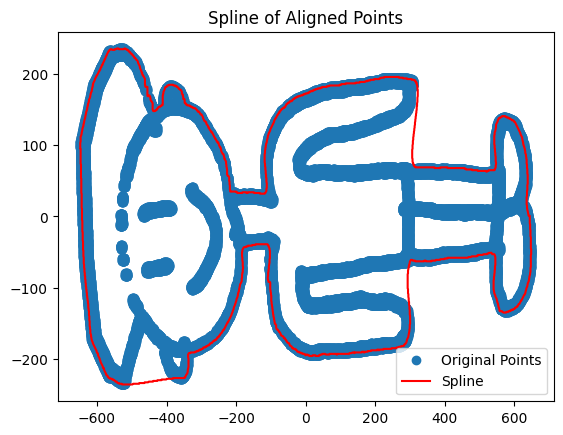

In [ ]:
# Ensure the points are unique
aligned_points = np.unique(aligned_points, axis=0)

# Define the threshold value
threshold = 250

# Reorder the aligned points (Needs to run twice to fully remove errors)
aligned_points_sorted = reorder_points(aligned_points, threshold)
aligned_points_sorted = reorder_points(aligned_points_sorted, threshold)

# Create a spline of the aligned points
tck, u = splprep([aligned_points_sorted[:, 0], aligned_points_sorted[:, 1]], s=0)

# Interpolation accuracy (number of points)
num_points2 = 3000

new_points = splev(np.linspace(0, 1, num_points2), tck)

# Round the new points to integers
new_points = np.round(np.array(new_points)).astype(int)

# Write the new points to a file
np.savetxt("points/interpolated_points.txt", new_points, delimiter=',')

# Plot the original points and the spline
plt.plot(trans_front[:, 0], trans_front[:, 1], 'o', label='Original Points')
plt.plot(new_points[0], new_points[1], 'r-', label='Spline')
plt.title('Spline of Aligned Points')
plt.legend()
plt.show()

In [11]:
# Load the interpolated points from file
new_points = np.loadtxt("points/interpolated_points.txt", delimiter=',')

### Fill gaps
In order to properly model the shape, no gaps can be left between points. We need every x value to exist, so if it doesn't we will average the nearest points to create a progression of points to fill the gap as best as we can

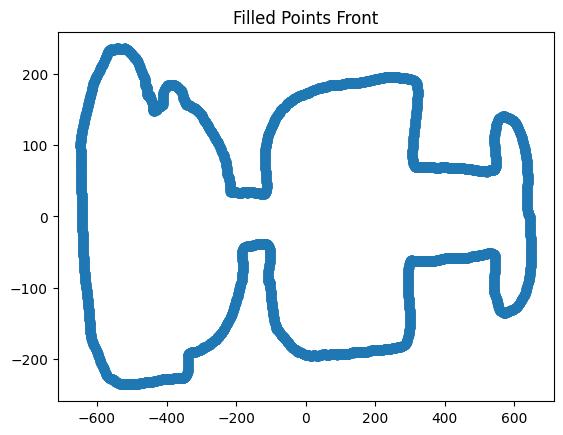

In [13]:
# Fill in the gaps between the points
filled_points_front = fill_gaps(np.unique(new_points, axis=0)).T
plt.plot(filled_points_front[:, 0], filled_points_front[:, 1], 'o')
plt.title('Filled Points Front')
plt.show()

### Create the depth vector
Use the side view to construct a depth vector. This will keep track of the locations in 3D space that the values should use

In [17]:
# Ensure that the points are integers
scaled_points_right = np.round(scaled_points_right).astype(int).T

In [18]:
# Initialize a dictionary to store the min and max y values for each x value
depth_vector = {}
x_min = np.min(filled_points_front[:, 0]).astype(int)
x_max = np.max(filled_points_front[:, 0]).astype(int)

# Iterate through the front view points
for x in range(x_min, x_max + 1):
    # Find the y values for the current x value
    mask = scaled_points_right[0] == x
    y_values = scaled_points_right[1][mask]

    if len(y_values) != 0:
        # If the x-value is present, store the min and max y values
        y_min = np.min(y_values).astype(int)
        y_max = np.max(y_values).astype(int)
    else:
        y_min = 0
        y_max = 0
        
        # If the x-value is not present, estimate from the closest present x-values
        x_vals = np.argsort(np.abs(scaled_points_right[0] - x))
        x1 = scaled_points_right[0][x_vals[0]]
        x2 = scaled_points_right[0][x_vals[1]]
        y1_min = np.min(scaled_points_right[1][scaled_points_right[0] == x1])
        y1_max = np.max(scaled_points_right[1][scaled_points_right[0] == x1])
        y2_min = np.min(scaled_points_right[1][scaled_points_right[0] == x2])
        y2_max = np.max(scaled_points_right[1][scaled_points_right[0] == x2])

        # Interpolate the y values based on proximity of the x-values
        if x1 == x2:
            y_min = y1_min
            y_max = y1_max
        else:
            weight1 = 1 - np.abs(x - x1) / np.abs(x1 - x2)
            weight2 = 1 - np.abs(x - x2) / np.abs(x1 - x2)
            y_min = int(y1_min * weight1 + y2_min * weight2)
            y_max = int(y1_max * weight1 + y2_max * weight2)

    # Store the min and max y values for the current x value
    depth_vector[x] = (y_min, y_max)

# Save the depth vector to a file
with open('points/depth_vector.pkl', 'wb') as f:
    pickle.dump(depth_vector, f)

In [15]:
depth_vector = {}

# Reload the depth vector from file
with open('points/depth_vector.pkl', 'rb') as f:
    depth_vector = pickle.load(f)

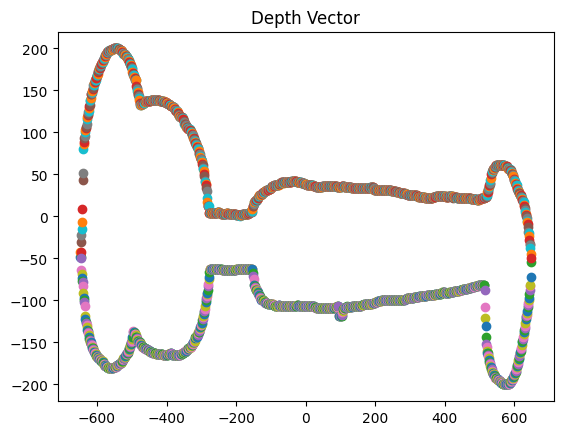

In [19]:
# Visualize the depth vector
for val in range(x_min, x_max + 1):
    plt.plot(val, depth_vector[val][0], 'o')
    plt.plot(val, depth_vector[val][1], 'o')
plt.title('Depth Vector')
plt.show()

### Construct the 3D representation
Using the depth vector to determine how thick each part should be by constructing a 3D vector with each part containing its values according to the min and max values within the depth vector


In [17]:
threed_points = []

# Iterate through the x-values to find the corresponding depth values and assemble the 3D space
for i in range(filled_points_front.shape[0]):
    x = filled_points_front[i, 0]
    y = filled_points_front[i, 1]
    z_min, z_max = depth_vector.get(x)
    for z in range(int(z_min), int(z_max) + 1):
        threed_points.append([x, y, z])

# Add points to fill the shape at the min and max z values
for x in range(x_min, x_max + 1):
    z_min, z_max = depth_vector.get(x)
    y_values = np.unique(filled_points_front[filled_points_front[:, 0] == x][:, 1])
    y_min = np.min(y_values).astype(int)
    y_max = np.max(y_values).astype(int)
    for val in range(y_min, y_max + 1):
        threed_points.append([x, val, int(z_min)])
        threed_points.append([x, val, int(z_max)])

threed_points = np.array(threed_points)

# Save the 3D points to a file
np.savetxt('points/threed_points.txt', threed_points, delimiter=',')

In [20]:
# Load the 3D points from file
threed_points = np.loadtxt('points/threed_points.txt', delimiter=',')

In [21]:
# Ensure that the points are the correct data type for Open3D
threed_points = threed_points.astype("float64")

In [22]:
pcl = o3d.geometry.PointCloud()
pcl.points = o3d.utility.Vector3dVector(threed_points)

# Save the point cloud to a file
o3d.io.write_point_cloud("point_clouds/model_point_cloud.ply", pcl)

True

In [ ]:
# Load the point cloud from file
pcl = o3d.io.read_point_cloud("point_clouds/model_point_cloud.ply")

In [23]:
o3d.visualization.draw_geometries([pcl])

### Create a Mesh using Marching Cubes
We convert the point cloud into a Voxel Grid to equalize the size of the points. Then we use the Marching Cubes algorithm to convert the Voxel Grid into an actual mesh

In [20]:
# Convert the point cloud to a voxel grid to equalize the point density
# Must set the voxel size to 1 to avoid losing points
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcl, voxel_size=1)

# Save the voxel grid to a file
o3d.io.write_voxel_grid("voxel_grids/model_voxel_grid.ply", voxel_grid)

True

In [ ]:
# Load the voxel grid from file
voxel_grid = o3d.io.read_voxel_grid("voxel_grids/model_voxel_grid.ply")

In [21]:
# Use numpy to extract the voxel grid points
voxel_indices = np.array([voxel.grid_index for voxel in voxel_grid.get_voxels()])
voxel_array = np.zeros((voxel_indices.max(axis=0) + 1), dtype=bool)
voxel_array[tuple(voxel_indices.T)] = True

# Convert the voxel grid to a mesh with the marching cubes algorithm
verts, faces, normals, values = measure.marching_cubes(voxel_array, level=0)

In [149]:
# Correct the data types for Open3D
verts = verts.astype("float64")
faces = faces.astype("int32")
normals = normals.astype("float64")

In [151]:
# Create an Open3D mesh
mesh = o3d.geometry.TriangleMesh()
mesh.vertices = o3d.utility.Vector3dVector(verts)
mesh.triangles = o3d.utility.Vector3iVector(faces)
mesh.vertex_normals = o3d.utility.Vector3dVector(normals)

# Save the mesh
o3d.io.write_triangle_mesh("meshes/model_mesh.ply", mesh)
o3d.io.write_triangle_mesh("meshes/model_mesh.obj", mesh) # 3D Editor Format

True

In [24]:
# Load the mesh
mesh = o3d.io.read_triangle_mesh("meshes/model_mesh.ply")

In [25]:
o3d.visualization.draw_geometries([mesh])